<a href="https://colab.research.google.com/github/Anguschen1011/Self-practice/blob/main/Forex_EUR_USD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare EUR/USD data for training

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 讀取 CSV 檔案
EURUSD_file = '/content/drive/MyDrive/Dataset/Forex/Cleaned/EUR_USD.csv'
df = pd.read_csv(EURUSD_file)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5000 non-null   object 
 1   Price   5000 non-null   float64
 2   Open    5000 non-null   float64
 3   High    5000 non-null   float64
 4   Low     5000 non-null   float64
dtypes: float64(4), object(1)
memory usage: 195.4+ KB
None


In [2]:
# 轉換日期欄位為 datetime 格式
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# 使用 Price 資料進行預測，所以只保留 'Price' 欄位
data = df['Price'].values.reshape(-1, 1)

# 正規化資料至 0 到 1 之間
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [3]:
from sklearn.model_selection import train_test_split

# 將資料分割為訓練集和測試集
train_data, test_data = train_test_split(data_scaled, test_size=0.05, random_state=42)

# train_data: 訓練集資料
# test_data: 測試集資料
print("Train data : ", len(train_data))
print("Test data : ", len(test_data))

Train data :  4750
Test data :  250


In [4]:
# 創建訓練資料和標籤
def create_dataset(dataset, time_step=1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        data_X.append(a)
        data_Y.append(dataset[i + time_step, 0])
    return np.array(data_X), np.array(data_Y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
print("Data after time_step : ")
print("X_train : ", len(X_train), "; y_train : ", len(y_train))
print("X_test : ", len(X_test), "; y_test : ", len(y_test))

Data after time_step : 
X_train :  4689 ; y_train :  4689
X_test :  189 ; y_test :  189


In [5]:
# 轉換為 3D 張量 [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Training

In [6]:
# 建立並訓練 LSTM 模型
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(LSTM(units=64))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 117619 (459.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
147/147 [==============================] - 40s 195ms/step - loss: 0.0559
Epoch 2/50
147/147 [==============================] - 17s 113ms/step - loss: 0.0491
Epoch 3/50
147/147 [==============================] - 17s 113ms/step - loss: 0.0488
Epoch 4/50
147/147 [==============================] - 18s 122ms/step - loss: 0.0486
Epoch 5/50
147/147 [==============================] - 18s 122ms/step - loss: 0.0486
Epoch 6/50
147/147 [==============================] - 17s 113ms/step - loss: 0.0486
Epoch 7/50
147/147 [==============================] - 17s 115ms/step - loss: 0.0485
Epoch 8/50
147/147 [==============================] - 18s 120ms/step - loss: 0.0484
Epoch 9/50
147/147 [==============================] - 17s 116ms/step - loss: 0.0485
Epoch 10/50
147/147 [==============================] - 17s 117ms/step - loss: 0.0483
Epoch 11/50
147/147 [==============================] - 17s 112ms/step - loss: 0.0485
Epoch 12/50
147/147 [==============================] - 17s 113ms/step - lo

# Prediction

In [8]:
# Predictions on test data
y_pred = model.predict(X_test)
y_pred_inverse = scaler.inverse_transform(y_pred)  # Inverse transform predicted values
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))  # Inverse transform actual values

rmse = np.sqrt(np.mean(((y_pred_inverse - y_test) ** 2)))
rmse

6/6 [==============================] - 1s 41ms/step


0.7588778353179929

In [9]:
import pandas as pd

# Convert y_test_inverse and y_pred_inverse to pandas Series for easier manipulation
y_test_series = pd.Series(y_test_inverse.squeeze(), name='Actual')
y_pred_series = pd.Series(y_pred_inverse.squeeze(), name='Predicted')


# Combine into DataFrame
results_df = pd.concat([y_test_series, y_pred_series], axis=1)

# Print the DataFrame
print(results_df.to_string(index=False, justify='center'))


 Actual  Predicted
 1.4101  1.233229 
 0.9018  1.224552 
 1.0025  1.231356 
 1.1899  1.240562 
 1.1432  1.242137 
 1.3178  1.240639 
 1.2932  1.235527 
 1.2896  1.233624 
 1.3001  1.235786 
 0.9395  1.239393 
 1.3546  1.249038 
 1.1407  1.244673 
 1.2373  1.238803 
 1.2032  1.231545 
 1.1225  1.228404 
 1.3096  1.231516 
 1.1316  1.233607 
 1.5586  1.239100 
 1.3926  1.235455 
 1.2346  1.234007 
 1.2651  1.237718 
 1.3173  1.240651 
 1.0690  1.239317 
 1.3188  1.240311 
 1.3693  1.234973 
 1.3526  1.228880 
 1.1291  1.227569 
 1.1198  1.235109 
 0.8659  1.244083 
 1.2186  1.253953 
 1.0912  1.247816 
 1.1082  1.238740 
 1.1728  1.232112 
 1.3914  1.230185 
 1.0663  1.229822 
 0.9424  1.239322 
 1.4837  1.251974 
 1.1734  1.245192 
 1.1793  1.238672 
 1.1218  1.233592 
 1.2883  1.232255 
 1.2970  1.230036 
 1.3283  1.229704 
 0.8691  1.231372 
 1.1207  1.243423 
 1.2242  1.247622 
 1.0925  1.241833 
 1.3541  1.236337 
 0.9047  1.228611 
 1.3679  1.234654 
 1.3520  1.235469 
 1.2176  1.2

In [10]:
# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

Mean Absolute Error: 0.12727086987066522
Mean Squared Error: 0.026615053714741835


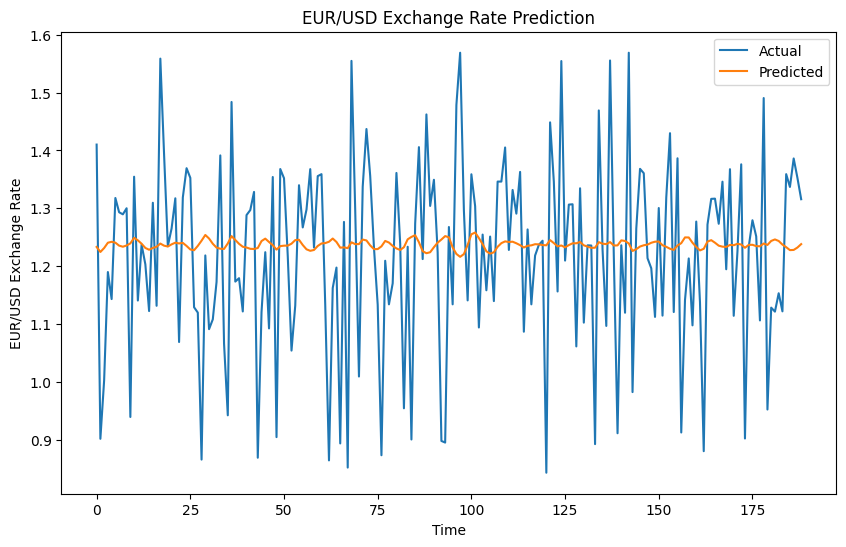

In [12]:
import matplotlib.pyplot as plt
# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label='Actual')
plt.plot(y_pred_inverse, label='Predicted')
plt.title('EUR/USD Exchange Rate Prediction')
plt.xlabel('Time')
plt.ylabel('EUR/USD Exchange Rate')
plt.legend()
plt.show()